In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

from tqdm.auto import tqdm as pbar

import logging

from ihrem.timeslice import Win, ms
from ihrem import paths
from ihrem import extract
import scipy.signal.windows

from ihrem.analysis import stim
from ihrem.figs_cpg import fig2

import warnings

warnings.simplefilter(action='error', category=FutureWarning)

pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.WARNING)

reg = paths.Registry.read_excel()
print(f'Found {len(reg)} experiments')

reg

Found 204 experiments


In [3]:
reg = reg.sel_mask([
    'GL1071_20210712_sleep6',
    'GL1071_20210714_sleep7',
])


# Extract sns

In [4]:
%%time

extract.extract_all_sne(
    reg,
    suffix='_cdf',
)

experiments: 0it [00:00, ?it/s]

CPU times: user 13.4 ms, sys: 3.38 ms, total: 16.8 ms
Wall time: 18.9 ms


In [5]:
%%time

tau = 10
sliding_win = tau * 10
kern = scipy.signal.windows.exponential(sliding_win, tau=tau)

extract.extract_all_xcorr(
    reg,
    sliding_win=sliding_win,
    areas=['CLA', 'BST'],
    kern=kern,
    suffix='_exp',
    mode='speed',
)

experiments: 0it [00:00, ?it/s]

CPU times: user 19.5 ms, sys: 1.42 ms, total: 20.9 ms
Wall time: 26.7 ms


# Analysis SNs


In [6]:


exp_sns = fig2.load_multi_sns(reg.sel_mask(reg['state'] == 'sleep'))

reg = reg.sel_mask(list(exp_sns.keys()))

valid_win = Win(ms(hours=2), ms(hours=11))

exp_light_wins = stim.load_light_wins_multi(reg, only_pulse=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
for sns in pbar(exp_sns.values()):
    sns['iei'] = np.nan
    
    sns['iei'] = sns['iei'].combine_first(
        sns.get_inter_event_intervals_between_channels(first_ch=0, second_ch=0)
    )
    
    sns['iei'] = sns['iei'].combine_first(
        sns.get_inter_event_intervals_between_channels(first_ch=1, second_ch=1)
    )

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
fig2.assign_sns_cat_multi(exp_sns, exp_light_wins, valid_win)

  0%|          | 0/2 [00:00<?, ?it/s]

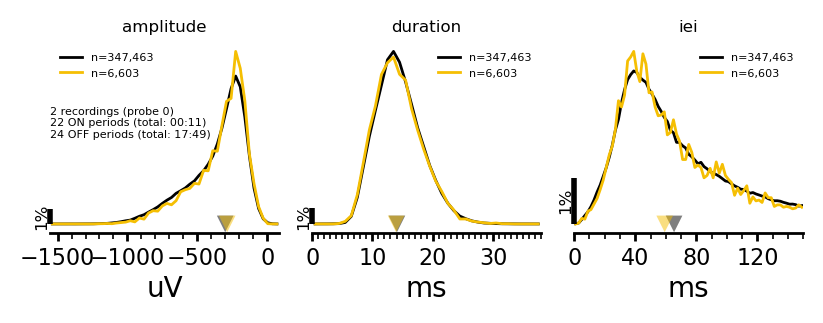

In [9]:
ref_ch = 0

f = fig2.plot_sn_stats_combined(exp_light_wins, exp_sns, reg.experiment_names, valid_win, ch=ref_ch)

f.savefig('../figs/sn_props_vs_light_pooled.pdf')